#### Import data

Start by running locally, we'll work our way up to reading from the internet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import pyreadr
import numpy as np
import mplcursors

In [2]:
# !pip install pyreadr
# !pip install mplcursors

-----------------------------------------------------------------------------------


## General Terms

The class system 'State' is a map of dictionaries that allow for features or 'paths' of descriptions in laymans terms of the features of the data.  Each state has different naming conventions on how it stores its data, so we then generate a set of easy to understand names to use.  After we have the easy-to-use names, we build a map that maps the easy-to-use names to the specific term the state uses.  From there, we can now write generalizable functions in terms of the easy-to-use names, and it works for every state as long as the map is set up.

First, we design a universal set of names to refer to information that is needed for our analysis.  These general terms are:
1.	**Year:** the year the sentencing occurred.
2.	**County:** the county of where the sentencing occurred.
3.	**District:** the district the sentencing occurred.
4.	**Race:** the race of the individual sentenced
5.	**Departure:** what kind of departure, if any occurred in the sentencing.  Levels could be Above Departure (sentencing greater than guideline), Within Range,  Below Range (sentence is below the guideline), or Indeterminable.
6.	**Judge:** the name of the Judge that sentenced the individual
7.	**Sex:** the sex of the individual sentenced

The idea here is we have these general, understandable terms.  State datasets vary from state to state, so we build a map to relate the general, usable term to the specific term the state uses.  This is useful for two reasons

1.	This map makes writing functions universal because of the maps.  Since we know that we can use, for example, Year to access the year data, we can always use Year rather than have to write a new function for every state.
2.	It makes reading and writing code easy to understand.  Rather than knowing durdep means duration in the Minnesota dataset, all you have to know is the general terms and the maps do all the hard work of relating the easy term to the hard one.


-----------------------------------------------------------

# Class State
Designed to be a container to hold all the necessary information for a specific state.  This class has 3 attributes
* Name:  Stores the name of the state
* Data: stores the dataframe for that state’s data
* Paths: this is a dictionary that maps the easy to use names to the specific names the state’s dataset uses.
* Paths always has 1 of the two formats:
    1. paths\[general term\] = \[specific_state_term\]
    2. paths\[general term\] = \[specific_state_term, dictionary describing the levels of that term\]
    
State objects are the core of this toolbox.  Every function is written with a state object being passed in.  The function takes the state object, then uses the genral terms, paths, and the states data to produce the desiered output.

In [3]:
class State:
    def __init__(self, inp_name, inp_data_url, inp_paths, 
                 order_of_outputs = ['Above Departure', 'Within Range', 'Below Range', 
                                        'Missing, Indeterminable, or Inapplicable']):
        self.name = inp_name
        
        
        url=inp_data_url
        url='https://drive.google.com/uc?id=' + url.split('/')[-2]
        self.data = pd.read_csv(url, low_memory = False)  # pandas dataframe object
        
        self.paths = inp_paths  # dictionary object.  
        # Always follows the format useful_id --> (name_in_data, dict(levels)).
        # Levels doesn't always exist, but is needed for variables like departure
        #path pairs are always (name_in_data, dict(levels)) or (name_in_data, None)
        
        self.order_of_outputs = order_of_outputs
        #this is how you want to arrange your output on graphs
        #is basically the order of the levels in paths[departure][1]
        
        self.average_percents= []  #list, for all years, state averages for all people
        self.yearly_average_percents = {}  # dictionary, state averages for all people for each year
                                             # format of: year (int) --> [averages_list]
        
        self.years = np.sort(self.data[self.paths['year'][0]].unique())  # generate a sorted list of years for data

        
        
        ###  get average_percents
        counts = self.data.groupby(self.paths['departure'][0]).count()
        counts = counts.rename(self.paths['departure'][1])
        counts = counts.iloc[:,0]

        for item in self.order_of_outputs:
            self.average_percents.append(round((100 * counts.loc[item]  /  self.data.shape[0]),2))
        
        ### get yearly_average_percents
        for year in self.years:
            subset_dat = self.data[ self.data[self.paths['year'][0] ] == year]
            counts = subset_dat.groupby(self.paths['departure'][0]).count()
            counts = counts.rename(self.paths['departure'][1])
            counts = counts.iloc[:,0]
            
            percentages = []
            for item in self.order_of_outputs:
                percentages.append(round((100 * counts.loc[item]  /  subset_dat.shape[0]),2))
            self.yearly_average_percents[year] = percentages
        

This code is setting up the minnesota state

In [4]:
states = {}  # dictionary to hold all states.  maps dict['state name'] --> state object for that state
paths = {}  # temporary paths dicitonary that will be passed into the creation of minnesota state object
paths['county'] = ['countyname', None]
paths['year'] = ['sentyear', None]
paths['district'] = ['district', None]
paths['race'] = ['race', {0:'NA', 
                         'white':'White', 
                         'black':'Black', 
                         'amind':'American Indian',
                         'hispanic': 'Hispanic',
                         'asian': 'Asian',
                         'other': ' Other',
                         None: 'Unknown'}]
paths['departure'] = ['durdep', {0:'Within Range', 
                                 1:'Above Departure', 
                                 2:'Below Range', 
                                 3:'Missing, Indeterminable, or Inapplicable'}]
paths['judge'] = ['judge', None]
paths['sex'] = ['sex', {1: 'Male', 
                        2: 'Female'}]
paths['age'] = ['Agecat', {1: 'Under 18', 
                           2: '18-21', 
                           3: '22-25', 
                           4: '26-30',
                           5: '31-40',
                           6: '41-50',
                           7: '51+'}]

#now that we have the information, we create the minnesota state object and add it to the states dictionary
states['minnesota'] = State('minnesota', 
                            'https://drive.google.com/file/d/1uz_-qgvObAPcB444fEhb_QizWSiKe-eg/view?usp=sharing', 
                            paths)

--------------------------------------------------

## Plot Types

### `Horizontal Bar Graph`
This function is used to plot a horizontal bar graph to view results.

**Parameters:**
* *departure_labels:* the labels on our departure variable.  This is the x labels
* *departure_proportions:* the proportions for each label.  This is the y label.
* *subgroup:* the subgroup that this bar graph corrosponds to (used in the title). Only used when looking at more than one level.
* *s:* for formatting, adds an s to the end of the title string

In [5]:
def plot_departures_bar(departure_labels, departure_porportions,base_group_str, subgroup, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (10,7))
    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    barh = ax.barh(departure_labels, departure_porportions, color=colors)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Percentage')
    
    ax.bar_label(barh, fmt='%.2f%%')
    ax.set_xlim(right=100)
    
    ttl = 'Proportional sentences for '+ base_group_str + ' ' + subgroup_str
    ax.set_title(ttl)

### `Pie Chart`

This function is used to plot a pie chart to view results.  This is just like the hoizontal bar graph, but a pie chart.

**Parameters:**
* *departure_labels:* the labels on our departure variable.  This is the x labels
* *departure_proportions:* the proportions for each label.  This is the y label.
* *subgroup:* the subgroup that this bar graph corrosponds to (used in the title).  Only used when looking at more than one level.
* *s:* for formatting, adds an s to the end of the title string

In [6]:
def plot_departures_pie(departure_labels, departure_porportions, base_group_str, subgroup, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (10,7))
    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    ax.pie(departure_porportions, labels=departure_labels, autopct='%1.1f%%', colors = colors)
    
    
    ttl = 'Proportional sentences for '+ base_group_str + ' ' + subgroup_str
    ax.set_title(ttl)

### `Stacked Bar Graph`
This function is used to plot a stacked horizontal bar graph to view results.

**Parameters:**
* *x_values_list:* the labels on our departure variable.  This is the x labels.  in the format of an 1 x number of subgroups
* *y_values_list:* the porportions for each label.  This is the y label.  In the format of (number of subgroups) x (number of items in the state's order of outouts)
* *base_group_str:* this is the beginning of the plot title string, some examples could be the state name, or a county or Judge name
* *subgroup:* the subgroup that this bar graph corrosponds to (used in the title).  Only used when looking at more than one level.
* *s:* for formatting, adds an s to the end of the title string

In [7]:
def plot_departures_stacked(x_values_list, y_values_list, base_group_str, subgroup, legend, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (12, 1 * len(x_values_list)))
    
    bar_colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    b = np.zeros(len(x_values_list))
    for i in range(len(y_values_list)):
        ax.barh(x_values_list, y_values_list[i], left = b, color = bar_colors[i], label = legend[i], edgecolor='black')
        b += y_values_list[i]
    ax.set_xlabel('Percentage')
    ax.set_xlim((-5,105))
    ttl = 'Proportional sentences for '+ base_group_str + ' ' + subgroup_str
    ax.set_title(ttl)
    ax.legend(bbox_to_anchor = (1.45, 0.6), loc='center right')
    

    # For each patch (basically each rectangle within the bar), add a label.
    #we are 
    len_to_beat = 0
    if isinstance(y_values_list[0], float):
        len_to_beat = 1
    else:
        len_to_beat = len(y_values_list[0])
        
    for i in range(len(ax.patches)):
        bar = ax.patches[i]
        if i < len_to_beat:  # above departure / first bar
            ax.text(
              bar.get_x() + bar.get_width()/2,
              bar.get_y() + bar.get_height() / 2,
              # This is actual value we'll show.
              str(round(bar.get_width(),2)) + '%',
              # Center the labels and style them a bit.
              ha='right',
              weight='bold',
              size=11)
        elif i < 3 * len_to_beat:  # second and third bars (in range, below range)
            ax.text(
              bar.get_x() + bar.get_width()/2,
              bar.get_y() + bar.get_height() / 2,
              # This is actual value we'll show.
              str(round(bar.get_width(),2)) + '%',
              # Center the labels and style them a bit.
              ha='center',
              weight='bold',
              size=11)
        else: # i % 4 == 3  last bar (missing, indeterminable, inapplicable)
            ax.text(
              bar.get_x() + bar.get_width()/2,
              bar.get_y() + bar.get_height() / 2,
              # This is actual value we'll show.
              str(round(bar.get_width(),2)) + '%',
              # Center the labels and style them a bit.
              ha='left',
              weight='bold',
              size=11)

_________________________________

## Judge Vs State Graphs

### `Judge vs State Bar Graph`
Plots a comparison horizontal bar graph comparing the state to the judge in question.

**Parameters:**
* *order_of_outputs:* a state objects order_of_outputs variable, used to deterimine the order of bars on the chart
* *section_averages:* the judge's averages.  In the shape of 1 x (length of order of outputs)
* *state_avg_for_years:* the state's averages.  In the shape of 1 x (length of order of outputs)
* *section_name:* name of the judge, for formatting the title
* *statename:* name of the state, for formatting the title

In [8]:
def plot_section_vs_state(order_of_outputs, section_averages, state_avg_for_years, section_name, statename):
    x = np.arange(len(order_of_outputs))
    y_data = {}
    y_data[section_name] = section_averages
    y_data[statename] = state_avg_for_years
    
    width = 0.35
    multiplier = 0
    
    bar_colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    fig, ax = plt.subplots(figsize = (10,7))

    for attribute, measurement in y_data.items():
        offset = width * multiplier
        rects = ax.barh(x + offset, measurement, width, label=attribute, color = bar_colors, edgecolor='black')
        ax.bar_label(rects, padding=3, fmt='%.2f%%' + '   ('+ attribute+')')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('percentage (%)')
    ttl = 'Comparing ' + section_name + ' sentencing to ' + statename + ' sentencing'
    ax.set_title(ttl)
    ax.set_yticks(x + width/2)
    ax.set_yticklabels(order_of_outputs)
    ax.set_xlim(0, 119)
    

### `Judge vs State Line Graph`
Plots a line graphs comparing the state to the judge in question.

**Parameters:**
* *stateobj:*  A state object.  Used to access the state's anme and order of outputs.
* *ovarlapping years:*  The years that the judge worked (whaich years of the state's data did the judge work in?)
* *section_data_y:* the section's averages.  In the shape of (number of overlapping years) x (length of order of outputs)
* *state_data_y:* the state's averages.  In the shape of (number of overlapping years) x (length of order of outputs)
* *section_name:* name of the judge, for formatting the title

In [9]:
def plot_section_vs_state_trends(stateobj, overlapping_years, section_data_y, state_data_y, section_name):
    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    for col in range(len(stateobj.order_of_outputs)):
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(overlapping_years, section_data_y[:,col], '-o', label=section_name, color = colors[col])
        ax.plot(overlapping_years, state_data_y[:,col], '--o', label=stateobj.name, color = colors[col])
        ttl = 'Comparing ' + section_name + ' and' + stateobj.name + ' on ' + stateobj.order_of_outputs[col]
        ax.set_title(ttl)
        ax.set_xlabel('year')
        ax.set_ylabel('percentage (%)')
        ax.legend(loc = 'upper right')
    

    fig, ax = plt.subplots(figsize=(10, 7))
    for col in range(len(stateobj.order_of_outputs)):
        ax.plot(overlapping_years, section_data_y[:,col] - state_data_y[:,col], '-o', 
                label=stateobj.order_of_outputs[col], color = colors[col])
    ax.axhline(y = 0, color = 'black')
    
    ttl = 'Comparing ' + section_name + ' difference from ' + stateobj.name + ' levels'
    ax.set_title(ttl)
    ax.set_xlabel('year')
    ax.set_ylabel('percentage (%)')
    ax.legend(loc = 'upper right')

---------------------------------------

## Helper Functions

### `Filter Years`
returns a filtered copy of a state's data for the desired years

**Parameters:**
* *stateobj:* a state object
* *years:* the specified years.  Either a range or none

In [10]:
def filter_years(stateobj, years):
    '''
    Every funciton has a years to filter parameter, so we are building a function here because:
    1.  if we have to edit it, we only have to edit it here
    2.  saves us time from rewriting this a bunch
    Parameters:
    stateobj: a state object
    years: the specified years.  Either a range or none
    '''
    subset_dat = stateobj.data
    if years is not None:  
        # if the user specifies a year range, filter the data for those years
        subset_dat = stateobj.data[stateobj.data[stateobj.paths['year'][0]].isin(years)]
    return subset_dat

### `Calculate State Average for Year`

This function calculates the state's averages for a select span of years.  It uses the state's yearly_average_percents and calculates the mean for the selected years by using the second parameter 'years'.

**Parameters:**
* *stateobj:* a state object
* *years:* the specified years.  Either a range or none

In [11]:
def calc_state_avg_for_yearspan(stateobj, years):
    avg_for_yearspan = []
    for year in years:
        avg_for_yearspan.append(stateobj.yearly_average_percents[year])
    avg_for_yearspan = np.array(avg_for_yearspan)
    means = np.mean(avg_for_yearspan, axis = 0)  # take the average of each column
    rounded = means.round(2)
    return rounded

### `Plotting the Dataframe as Desired Plot Type`
This is the main plotting function for generalizable_multi_level_summary and subset_multi_level_summary.  This function takes a state, the percentages to plot, the plot type, and any subgroups to make plots for (in case we are grouping by more than just departure).

Using this data, it creates the desired plots for the user to view

**Parameters:**
* *df:* input dataframe.  Right now we are using percents from generalizable_multi_level_summary
* *stacked:* if true, produce stacked bar graphs, if false, produce nonstacked bar graphs
* *groups:* the parameters we are grouping by, we use these to generate titles in stacked bar graphs

In [12]:
def plot_df(stateobj, df, plot_type, groups, base_group_str):
    '''
    Main plotting function.  This is used by generalizable_multi_level_summary to take a dataframe and generate 
    graphs by calling plot_departures or plot_departures_stacked.
    
    we have 6 main situations here
    1. stacked bar, just departure to group by
    2. stacked bar, more than just deaprture to group by
    3. not stacked bar, just departure
    4. not stacked bar, more than just departure
    5. pie chart, just departure
    6. pie chart, more than just departure
    
    each situation is handeled in the plotting phase
    '''
    unique_identifiers = []  # list of unique tuples in df.index we will need
    unique_identifier_strings = []  # string fromat of unique_identifiers, used in graph titles.
    if  df.index.nlevels > 1:
        for ind in df.index:
            if ind[:-1] not in unique_identifiers:  # we do ind[:-1] here because the last identifier is always departure, and we want our grops to be everything but departure 
                unique_identifiers.append(ind[:-1])  # add the unique identifier tuple
                # create and add string form of the unique identifier to unique_identifier_strings
                unique_identifier_string = ''
                for string in ind[:-1]:
                    unique_identifier_string += str(string) + ' '
                unique_identifier_string = unique_identifier_string[:-1]
                unique_identifier_strings.append(unique_identifier_string)
    else:
        unique_identifier_strings = [stateobj.order_of_outputs]
                
    # plotting time.
    if plot_type == 'stacked bar':
        if len(groups) > 0:  #we're dealing with more then one grouping variable
            porportions = np.zeros((len(stateobj.order_of_outputs), len(unique_identifiers)))
            for dep in range(len(stateobj.order_of_outputs)):
                for unique_id in range(len(unique_identifiers)):
                    loc_id = unique_identifiers[unique_id] + (stateobj.order_of_outputs[dep],)
                    if loc_id in df.index:
                        porportions[dep, unique_id] = df.loc[loc_id,]
            #plot
            plot_departures_stacked(unique_identifier_strings, porportions, base_group_str, groups, stateobj.order_of_outputs)
        else:  # just departure
            porportions = []
            for departure_type in stateobj.order_of_outputs:
                porportions.append(df.loc[departure_type,])
            #plot
            groups.insert(0, stateobj.name)  # we need the state name for plotting purposes
            plot_departures_stacked([stateobj.name], porportions, base_group_str, groups, stateobj.order_of_outputs, s = False)
            
    if plot_type == 'bar' or plot_type == 'pie':  # not stacked bars
        if len(groups) > 0:  #we're dealing with more then one grouping variable
            for unique_id in unique_identifiers:
                porportions = [0,0,0,0]
                pos = 0
                for deperture_type in stateobj.order_of_outputs:
                    comb_ind = unique_id + (deperture_type,)
                    if comb_ind in df.index:
                        porportions[pos] = df.loc[comb_ind,]
                    pos += 1
                    
                unique_id = (stateobj.name,) + unique_id
                if plot_type == 'bar':
                    plot_departures_bar(stateobj.order_of_outputs, porportions, base_group_str, unique_id)
                else:  # pie
                    plot_departures_pie(stateobj.order_of_outputs, porportions, base_group_str, unique_id)
        else:
            porportions = []
            for departure_type in stateobj.order_of_outputs:
                porportions.append(df.loc[departure_type,])
            if plot_type == 'bar':
                plot_departures_bar(stateobj.order_of_outputs, porportions, base_group_str, [], s = False) 
            else:  # pie
                plot_departures_pie(stateobj.order_of_outputs, porportions, base_group_str, [], s = False)  


### `Filtered Multi-Level Summary`

A slightly modified version of generalizable_multi_level_summary.  This is built to work with already filtered data.  It is used in individual_section_analysis.

**Parameters:**
* *stateobj:* a state object
* *subset_dat:* the subset of data based on years, use filter_years to get subset of data
* *base_group_str:* the specified years.  Either a range or none
* *inp_list_of_groups:* default is the sentencing departure ranges, can add other columns values to compare
* *plot:* Choose type of plot based off of ('stacked bar', 'bar', 'pie')

In [13]:
def subset_data_multi_level_summary(stateobj, subset_dat, base_group_str, inp_list_of_groups = ['departure'], plot = 'stacked bar'):
    groups_to_filter_by = []  # this list keeps track of the column names in our stateobj.data we are grouping by
    # get the column names in our stateobj.data we are grouping by
    for group in inp_list_of_groups:
        groups_to_filter_by.append(stateobj.paths[group][0])
    #groups_to_filter_by.append(stateobj.paths['departure'][0])  # add departure as a group by on the end, as that is our 
                                                                # the variable we are looking at
    
    #grouping by 
   
    counts = subset_dat.groupby(groups_to_filter_by).count()
    perc = None #initializing, will get value in next lines
    if len(inp_list_of_groups) > 1: # if we are grouping by more than departure
        perc = round(100 * counts / subset_dat.groupby(groups_to_filter_by[:-1]).count(), 1)
    else:
        perc = round( (100 * counts/ subset_dat.shape[0]),2)  #if we are just grouping by departure, we divide by data frame length
    
    # renames the values that have levels
    l=0
    for group in inp_list_of_groups:
        if stateobj.paths[group][1] is not None:
            perc = perc.rename(stateobj.paths[group][1], level = l)
            counts = counts.rename(stateobj.paths[group][1], level = l)
        l += 1
    # pull the data we need from our dataframes    
    perc = perc.iloc[:,0]  # all columns are the same, so we pull the first one
    counts = counts.iloc[:,0]  # all columns are the same, so we pull the first one
    
    #create an output dataframe to return
    comb_df = pd.concat([counts,perc],axis=1)  # combine our two columns into a dataframe
    comb_df.columns = ['count', 'percent']  # rename columns 
    if plot == 'stacked bar':
        plot_df(stateobj, perc, 'stacked bar', inp_list_of_groups[:-1], base_group_str)  # call our plotting function
    elif plot == 'bar':
        plot_df(stateobj, perc, 'bar', inp_list_of_groups[:-1], base_group_str)
    elif plot == 'pie':
        plot_df(stateobj, counts, 'pie', inp_list_of_groups[:-1], base_group_str)

    return comb_df

-------------------------------------------------------------

# Analysis Functions

### `Trends for States Average Path Value`

This function plots the state trends over time.

**Parameters:**
* *stateobj:* the state in question.  We need the state's yearly_average_percents to plot the graph
* *compressed:* if true, plot all lines on one graph.  If false, plot all lines on separate graphs.

In [14]:
def state_trends(stateobj, compressed = False):
    state_data_y = np.zeros((len(stateobj.years), len(stateobj.order_of_outputs)))
    for year in range(len(stateobj.years)):
        state_data_y[year] = stateobj.yearly_average_percents[stateobj.years[year]]

    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    if compressed:
        fig, ax = plt.subplots(figsize=(10, 7))
        for col in range(len(stateobj.order_of_outputs)):
            ax.plot(stateobj.years, state_data_y[:,col], '-o', label=stateobj.order_of_outputs[col], color = colors[col])
        ttl = stateobj.name + ' Trends'
        ax.legend()
        ax.set_title(ttl)
        ax.set_xlabel('year')
        ax.set_ylabel('percentage (%)')
    else:
        for col in range(len(stateobj.order_of_outputs)):
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(stateobj.years, state_data_y[:,col], '-o', color = colors[col])
            ttl = stateobj.name + ' ' + stateobj.order_of_outputs[col] + ' over time.'
            ax.set_title(ttl)
            ax.set_xlabel('year')
            ax.set_ylabel('percentage (%)')
            

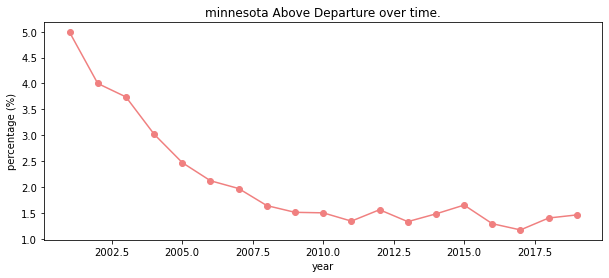

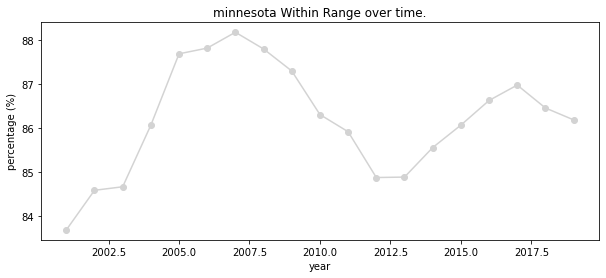

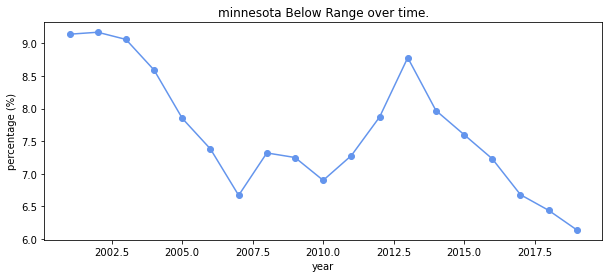

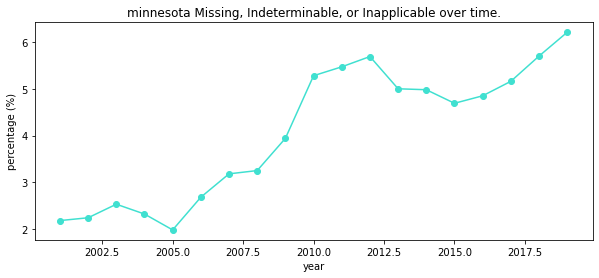

In [15]:
state_trends(states['minnesota'], compressed = False)

### `Generalizable Multi-Level Summary`

Grouping by any combination (or none) of factor variables.  There is only one assumption to calling this function: the last level passed into inp_list_of_groups.  Basically, calling with only \['departure'\] means we are not grouping by any factor variable. This is a multi-level analysis of the path groups that are specified using the inp_list_of_groups parameter. Using the plot parameter you can specify if you want a bar, stacked bar or pie. 

**Parameters:**
* *stateobj:* the state in question.  We need the state's yearly_average_percents to plot the graph
* *inp_list_of_groups:* Choose path description using string name
* *years:* the specified years.  Either a range or none
* *plot:* Choose type of plot based off of ('stacked bar', 'bar', 'pie')

In [16]:
def generalizable_multi_level_summary(stateobj, inp_list_of_groups = ['departure'], years = None, plot = 'stacked bar'):
    # we should have a subplots vs stacked parameter here maybe?  either do lots of individual graphs or stacked
    subset_dat = filter_years(stateobj, years)  #first, filter for the years we are looking for
    return subset_data_multi_level_summary(stateobj, subset_dat, stateobj.name, inp_list_of_groups, plot)

count  percent
race            durdep                                                   
American Indian Within Range                               18509     88.8
                Above Departure                              440      2.1
                Below Range                                 1424      6.8
                Missing, Indeterminable, or Inapplicable     482      2.3
Asian           Within Range                                6049     85.5
                Above Departure                              128      1.8
                Below Range                                  501      7.1
                Missing, Indeterminable, or Inapplicable     394      5.6
Black           Within Range                               61519     79.9
                Above Departure                             2051      2.7
                Below Range                                 9576     12.4
                Missing, Indeterminable, or Inapplicable    3828      5.0
Hispanic        Within Range                               13938     86.7
                Above Departure                              297      1.8
                Below Range                                 1183      7.4
                Missing, Indeterminable, or Inapplicable     659      4.1
 Other          Within Range                                 186     84.5
                Above Departure                                5      2.3
                Below Range                                   11      5.0
                Missing, Indeterminable, or Inapplicable      18      8.2
White           Within Range                              152762     88.8
                Above Departure                             2934      1.7
                Below Range                                 9513      5.5
                Missing, Indeterminable, or Inapplicable    6804      4.0

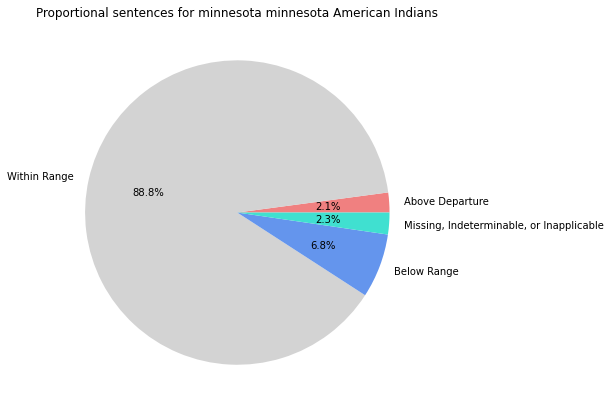

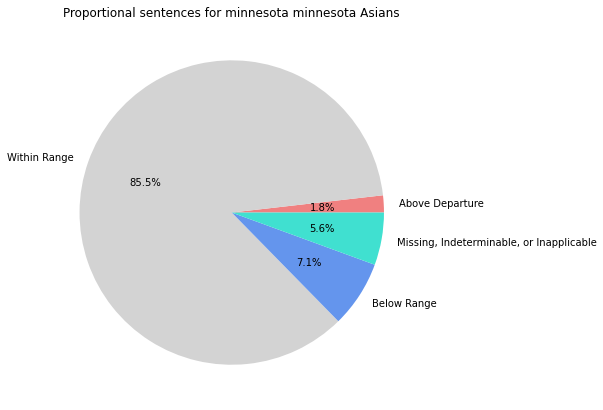

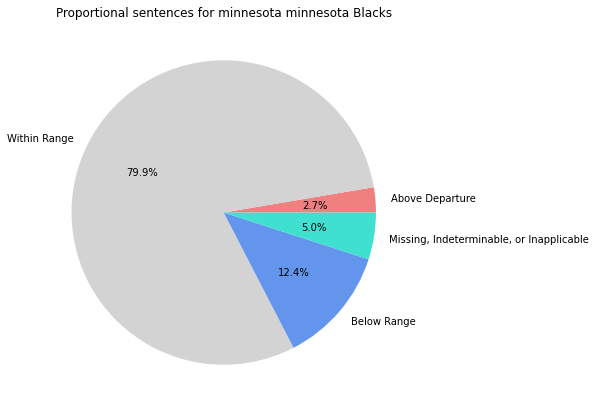

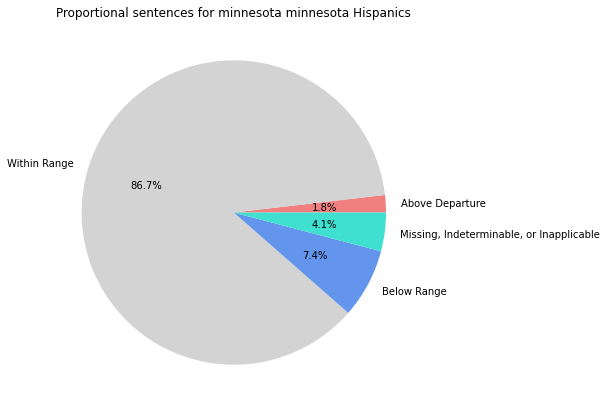

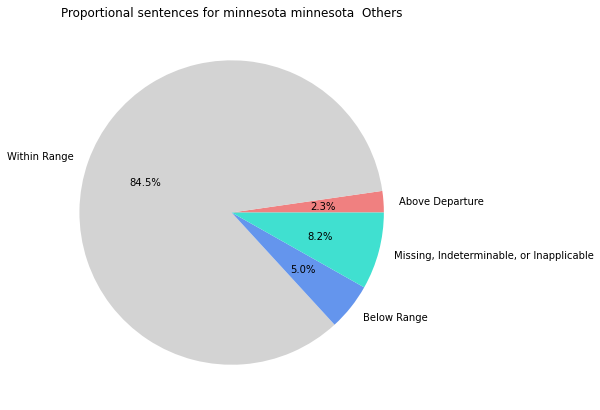

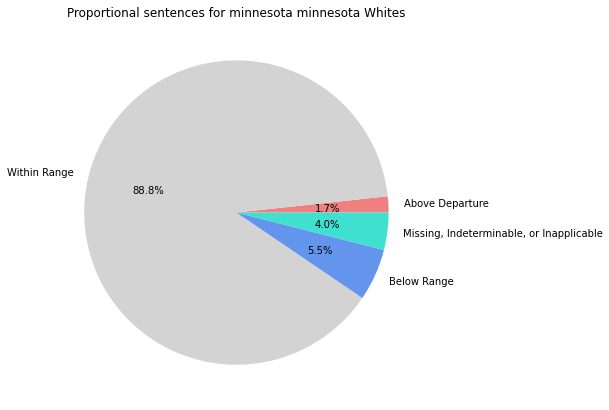

In [17]:
generalizable_multi_level_summary(states['minnesota'], inp_list_of_groups = ['race','departure'], years = None, plot = 'pie')

### `Basic Individual section Analysis`

This plots the change over time for a certain county / judge.

**Parameters:**
* *stateobj:* a state object
* *section_name:* can input the name of a Judge or a Region Name within State
* *base_group_str:* the specified years.  Either a range or none
* *inp_list_of_groups:* default is the sentencing departure ranges, can add other columns values to compare
* *plot:* Choose type of plot based off of ('stacked bar', 'bar', 'pie')

In [18]:
def individual_section_analysis(stateobj, section_name, inp_list_of_groups = ['departure'], years = None, plot = True):
    section_filtered_data = stateobj.data[stateobj.data[stateobj.paths['judge'][0]]== section_name]
    # get the years where the judge was active
    overlapping_years = years
    if years is None:
        overlapping_years = np.sort(section_filtered_data[stateobj.paths['year'][0]].unique())
    print(section_name, 'was active in the years:', overlapping_years)
    
    groups_to_filter_by = []  # this list keeps track of the column names in our stateobj.data we are grouping by
    # get the column names in our stateobj.data we are grouping by
    for group in inp_list_of_groups:
        groups_to_filter_by.append(stateobj.paths[group][0])
    #groups_to_filter_by.append(stateobj.paths['departure'][0])  # add departure as a group by on the end, as that is our 
                                                                # the variable we are looking at
    
    #time to get the aggregate
    
    
    #grouping by 
    #divide by count(all_items_but_daparture) for departure percentages for each subgroup
    counts = section_filtered_data.groupby(stateobj.paths['departure'][0]).count()
    perc = round( (100 * counts/ section_filtered_data.shape[0]),2)  #if we are just grouping by departure, 
                                                                   #we divide by data frame length
    # renames the values that have levels
    perc = perc.rename(stateobj.paths['departure'][1], level = 0)
    counts = counts.rename(stateobj.paths['departure'][1], level = 0)

    # pull the data we need from our dataframes    
    perc = perc.iloc[:,0]  # all columns are the same, so we pull the first one
    counts = counts.iloc[:,0]  # all columns are the same, so we pull the first one
    
    #create an output dataframe to return
    agg_comb_df = pd.concat([counts,perc],axis=1)  # combine our two columns into a dataframe
    agg_comb_df.columns = ['count', 'percent']  # rename columns 
    
    state_avg_for_years = calc_state_avg_for_yearspan(stateobj, overlapping_years)
    section_averages = []
    for departure_type in stateobj.order_of_outputs:
        section_averages.append(perc.loc[departure_type,])
    
    if plot:
        plot_section_vs_state(stateobj.order_of_outputs, section_averages, 
                            state_avg_for_years, section_name, stateobj.name)
    
    #now we plot the changes over time vs the state
    section_data_y = np.zeros((len(overlapping_years), len(stateobj.order_of_outputs)))
    state_data_y = np.zeros((len(overlapping_years), len(stateobj.order_of_outputs)))
    for year in range(len(overlapping_years)):
        section_year_data = section_filtered_data[section_filtered_data[stateobj.paths['year'][0]]== overlapping_years[year]]
        perc = round( (100 * section_year_data.groupby(stateobj.paths['departure'][0]).count()/ section_year_data.shape[0]),2)
        perc = perc.rename(stateobj.paths['departure'][1], level = 0)
        perc = perc.iloc[:,0]
        
        for departure_type in range(len(stateobj.order_of_outputs)):
            if stateobj.order_of_outputs[departure_type] in perc.index:
                section_data_y[year, departure_type] = perc.loc[stateobj.order_of_outputs[departure_type]]
        
        state_data_y[year] = stateobj.yearly_average_percents[overlapping_years[year]]

    for departure_type in range(len(stateobj.order_of_outputs)):
        if section_data_y[-1, departure_type] >= state_data_y[-1, departure_type]:
            print(section_name, 'currently has a(n)', stateobj.order_of_outputs[departure_type], 'rate at or above state average in years queried')
        else:
            print(section_name, 'currently has a(n)', stateobj.order_of_outputs[departure_type], 'rate below state average in years queried')
    
    if plot:
        plot_section_vs_state_trends(stateobj, overlapping_years, section_data_y, state_data_y, section_name) 
        subset_data_multi_level_summary(stateobj, section_filtered_data, inp_list_of_groups, plot = 'stacked bar')

Cunningham, James was active in the years: [2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

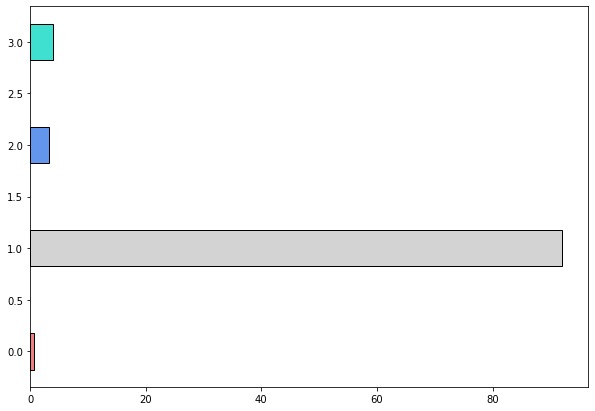

In [19]:
individual_section_analysis(states['minnesota'], 'Cunningham, James',
                                    inp_list_of_groups = ['race','departure'], years = None, plot = True)